In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import dateutil
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

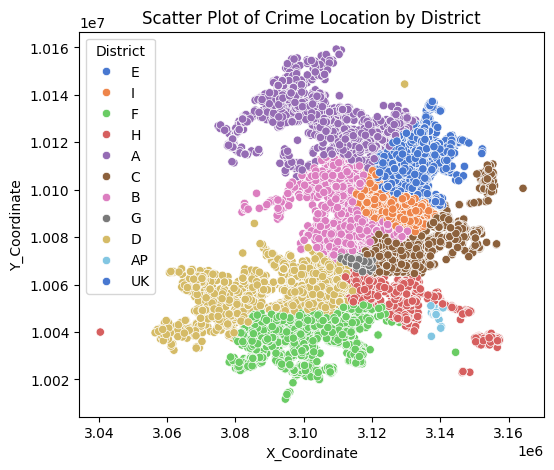

In [32]:
df = pd.read_csv('Core/crime-housing-austin-2015.csv')
plt.figure(figsize = (6,5))
sns.scatterplot(data=df, x='X_Coordinate', y='Y_Coordinate', palette='muted', hue='District')
plt.title("Scatter Plot of Crime Location by District")
plt.savefig('1a.jpg',dpi=600)
plt.show()

In [33]:
population = pd.read_csv('Core/AustinZipCodes.csv')
df['Medianhouseholdincome'] = df['Medianhouseholdincome'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['Populationbelowpovertylevel'] = df['Populationbelowpovertylevel'].str.rstrip('%').astype(float)
df['Unemployment'] = df['Unemployment'].str.rstrip('%').astype(float).astype(float)
df['Medianhomevalue'] = df['Medianhomevalue'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df = df.dropna(subset = ['Zip_Code_Crime'], axis=0)
df.Zip_Code_Crime = df.Zip_Code_Crime.astype(int).astype(str)
data_zip = df.groupby(by='Zip_Code_Crime').agg({'Key':'size','Populationbelowpovertylevel':'mean','Medianhouseholdincome':'mean','Unemployment':'mean','Medianhomevalue':'mean'}).reset_index()

In [34]:
population['Zip Code']=population['Zip Code'].astype(str)
data_zip=data_zip.merge(population,left_on='Zip_Code_Crime',right_on='Zip Code').drop(['Zip Code', 'Location', 'City', 'National Rank'],axis=1)
data_zip['Population'] = data_zip['Population'].str.replace(',', '').astype(int)
data_zip['Crimerate'] = data_zip.Key/data_zip.Population

<Figure size 1000x800 with 0 Axes>

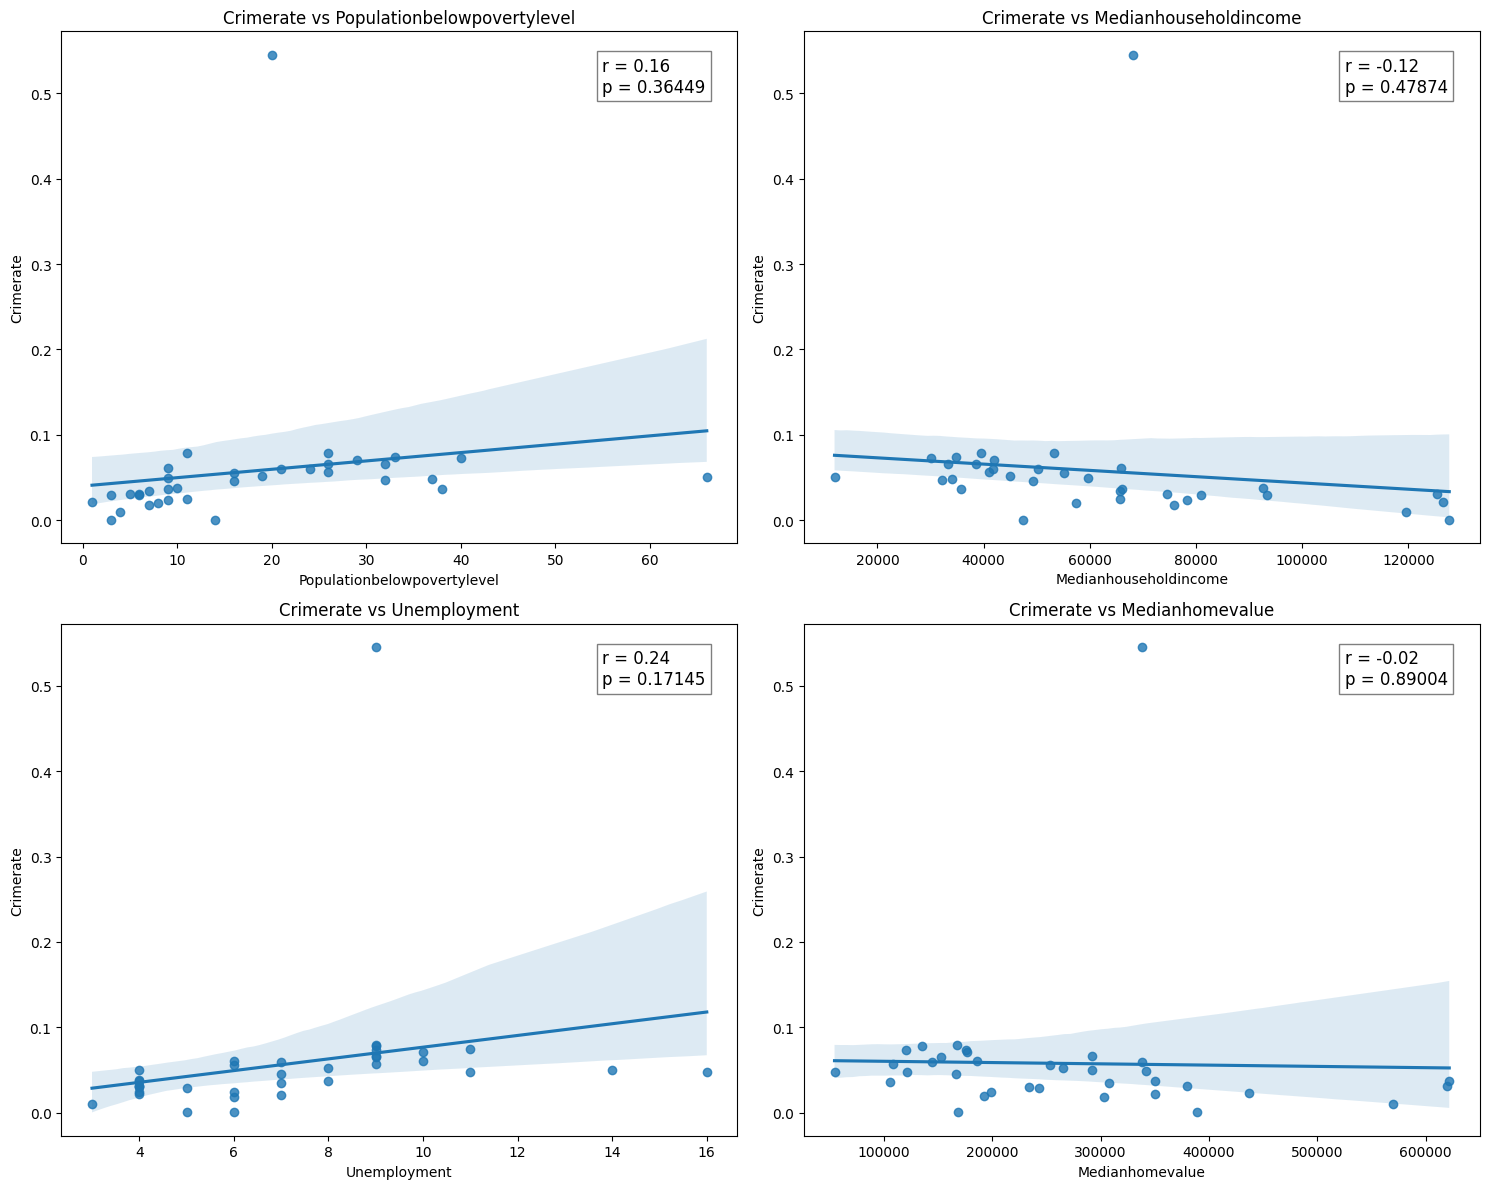

In [35]:
columns = ['Populationbelowpovertylevel', 'Medianhouseholdincome', 'Unemployment', 'Medianhomevalue']
titles = ['Crimerate vs Populationbelowpovertylevel', 
          'Crimerate vs Medianhouseholdincome', 
          'Crimerate vs Unemployment', 
          'Crimerate vs Medianhomevalue']
plt.figure(figsize=(10,8))
def annotate(ax, x, y, data):
    data = data.dropna()
    r, p = stats.pearsonr(data[x], data[y])
    ax.text(0.80, 0.95, f'r = {r:.2f}\np = {p:.5f}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    col = columns[i]
    sns.regplot(x=col, y='Crimerate', data=data_zip, ax=ax)
    ax.set_title(titles[i])
    annotate(ax, col, 'Crimerate', data_zip)

plt.tight_layout()
plt.savefig('2a.jpg', dpi=300)
plt.show()

### We removed one anomalous value that was biasing our regression analysis to ensure more accurate and reliable results. This adjustment helps to prevent skewed interpretations and better reflects the true relationship between the variables under investigation.

<Figure size 800x700 with 0 Axes>

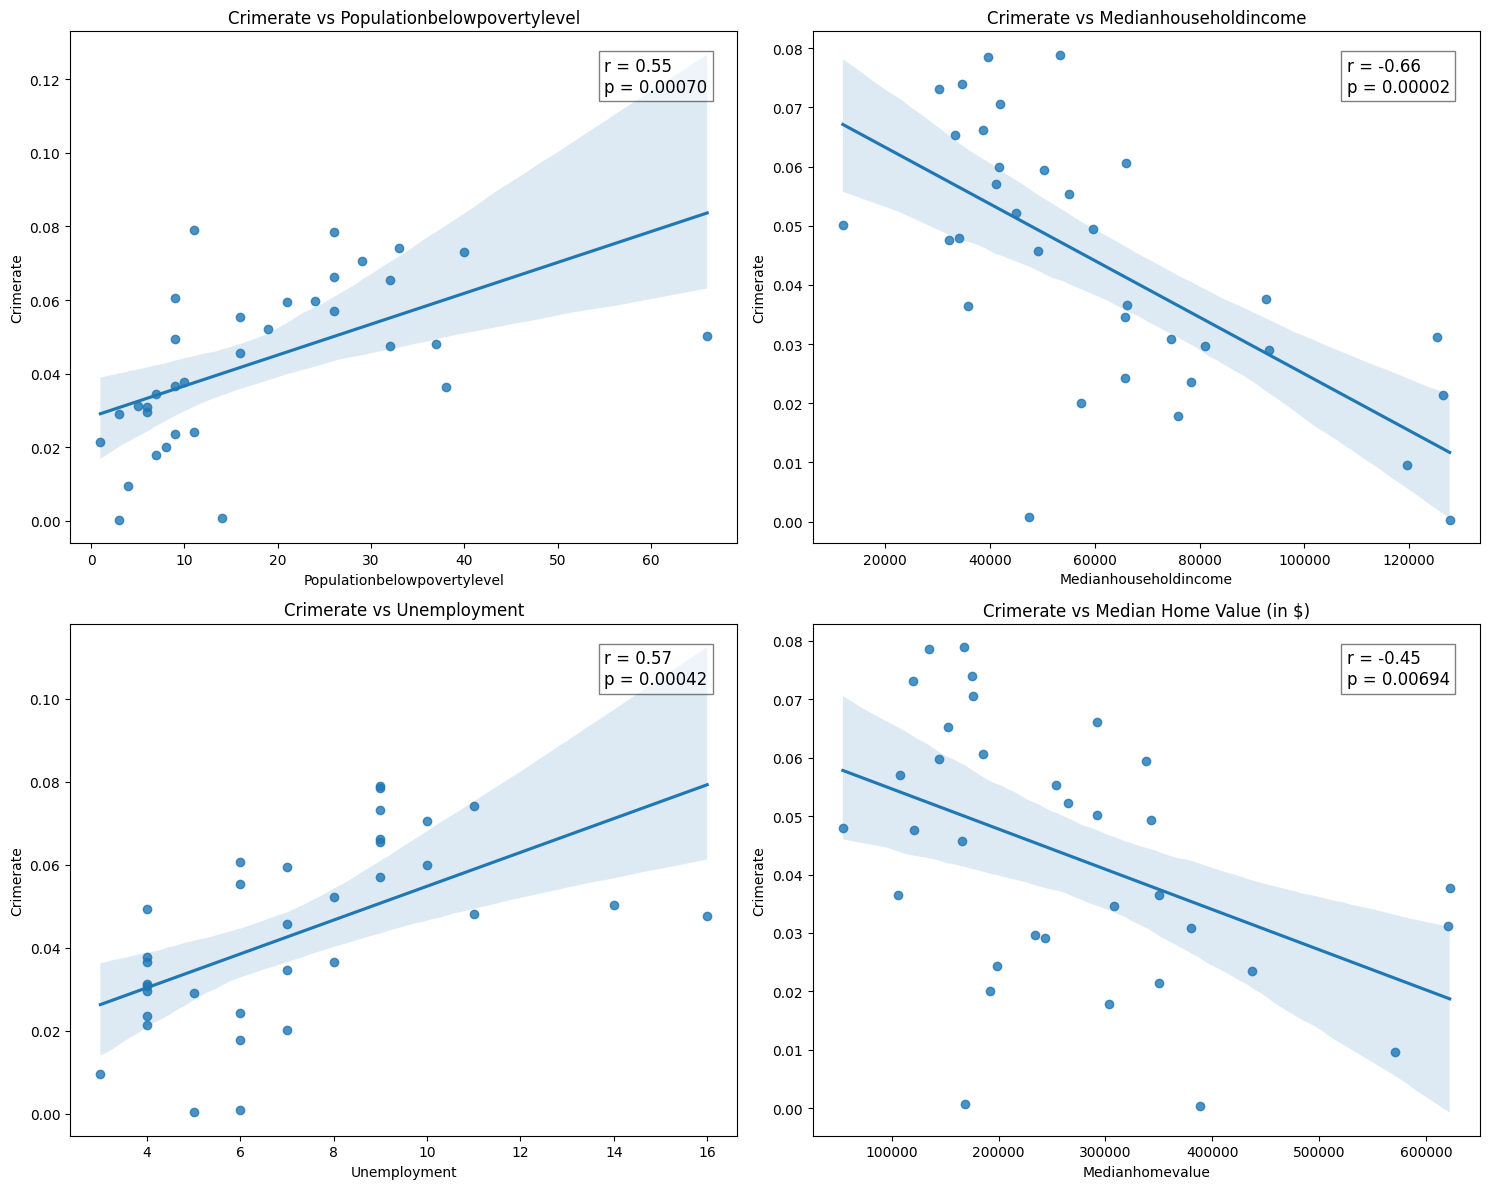

In [36]:
data_zip = data_zip[data_zip.Crimerate<0.5]
columns = ['Populationbelowpovertylevel', 'Medianhouseholdincome', 'Unemployment', 'Medianhomevalue']
titles = ['Crimerate vs Populationbelowpovertylevel', 
          'Crimerate vs Medianhouseholdincome', 
          'Crimerate vs Unemployment', 
          'Crimerate vs Median Home Value (in $)']

# Function to annotate plots with r and p-value
plt.figure(figsize=(8,7))
def annotate(ax, x, y, data):
    data = data.dropna()
    r, p = stats.pearsonr(data[x], data[y])
    ax.text(0.80, 0.95, f'r = {r:.2f}\np = {p:.5f}', 
            transform=ax.transAxes, verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loop through the axes and columns
for i, ax in enumerate(axes.flat):
    col = columns[i]
    sns.regplot(x=col, y='Crimerate', data=data_zip, ax=ax)
    ax.set_title(titles[i])
    annotate(ax, col, 'Crimerate', data_zip)

# Adjust layout
plt.tight_layout()
plt.savefig('1b.jpg',dpi=300)
plt.show()

In [37]:
for column, title in zip(columns,titles):
    print("\n"+title)
    data_notnull = data_zip.dropna(subset=column)
    display(stats.pearsonr(data_notnull.Crimerate, data_notnull[column]))


Crimerate vs Populationbelowpovertylevel


PearsonRResult(statistic=0.5529362259948573, pvalue=0.000695385785066734)


Crimerate vs Medianhouseholdincome


PearsonRResult(statistic=-0.6583575925756772, pvalue=2.3126276203441827e-05)


Crimerate vs Unemployment


PearsonRResult(statistic=0.570775758391258, pvalue=0.00042350726376412826)


Crimerate vs Median Home Value (in $)


PearsonRResult(statistic=-0.45440739160137306, pvalue=0.006939371362101515)

Key takeaway: Crime rates tend to be higher in neighborhoods with lower median household incomes, higher poverty levels, and higher unemployment rates. Conversely, neighborhoods with higher median home values and higher median household incomes generally experience lower crime rates.

## Crime by District

In [42]:
austin_zip = pd.read_csv("Core/AustinZipCodes.csv")
austin_crime = pd.read_csv("Core/crime-housing-austin-2015.csv")
austin_zip['Population'] = austin_zip['Population'].str.replace(',','').astype(int)
zip_code_crime = pd.merge(austin_crime, austin_zip, left_on="Zip_Code_Crime", right_on="Zip Code")
crime_by_district = zip_code_crime.groupby(["District",'Zip_Code_Crime']).agg({'Key':'size','Population':'mean'}).reset_index()
crime_by_district = crime_by_district.groupby("District").agg({'Key':'sum','Population':'sum'})

crime_by_district['crime_rate'] = crime_by_district.Key/crime_by_district.Population
crime_by_district = crime_by_district.reset_index()

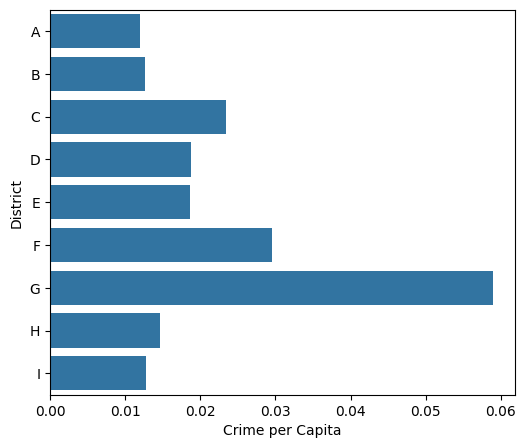

In [43]:
plt.figure(figsize=(6,5))
sns.barplot(crime_by_district[(crime_by_district.District != 'AP') & (crime_by_district.District != 'UK')] , x='crime_rate', y = 'District')
plt.xlabel('Crime per Capita')
plt.savefig('3.jpg',dpi=300)

<Axes: xlabel='Population', ylabel='District'>

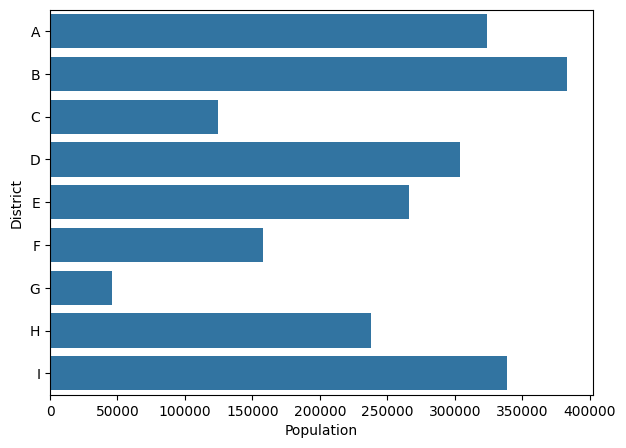

In [44]:
plt.figure(figsize=(7,5))
sns.barplot(crime_by_district[(crime_by_district.District != 'AP') & (crime_by_district.District != 'UK')], x='Population', y ='District')

In [46]:
def days_between(d1, d2):
    if d1 == "NA" or d2 == "NA":
        return -1
    d1 = datetime.strptime(d1, "%d-%m-%y")
    d2 = datetime.strptime(d2, "%d-%m-%y")
    return abs((d2 - d1).days)

months = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

def convertDateMonth(raw_date):
    key = raw_date.split('-')[1]
    date = raw_date.replace(key, str(months[key]))
    return date

def report_period(reportDate, clearDate):
    if type(clearDate) == float:
        return -1
    rp_date = convertDateMonth(reportDate)
    cl_date = convertDateMonth(clearDate)
    return days_between(rp_date, cl_date)

austin_crime['Clearance_period'] = austin_crime.apply(lambda x: report_period(x.Report_Date, x.Clearance_Date), axis=1)
austin_crime = austin_crime[austin_crime.Clearance_period>= 0]

In [47]:
austin_crime.Clearance_period.describe()

count    36649.000000
mean        17.549292
std         30.148283
min          0.000000
25%          2.000000
50%          5.000000
75%         19.000000
max        364.000000
Name: Clearance_period, dtype: float64

In [48]:
status_C = austin_crime[austin_crime.Clearance_Status == "C"]

### Compare Report Period by District

### Is there a difference between George's and Adam's Report Period?

In [49]:
district_A = status_C[status_C.District == "A"]
district_G = status_C[status_C.District == "G"]

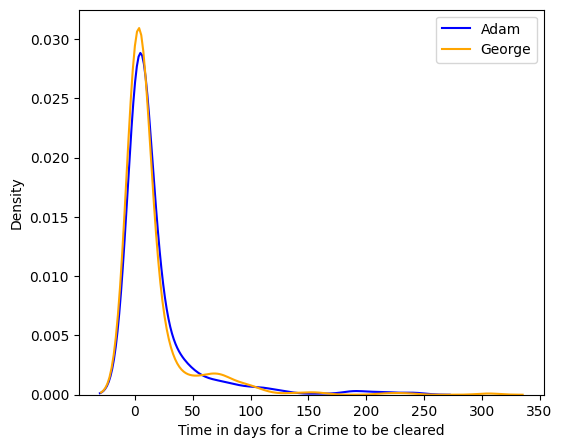

In [50]:
plt.figure(figsize = (6,5))
sns.kdeplot(district_A.Clearance_period, label="Adam",color='blue')
sns.kdeplot(district_G.Clearance_period, label="George",color='orange')
plt.xlabel('Time in days for a Crime to be cleared')
plt.legend()
plt.savefig('5.jpg',dpi=300)

In [51]:
district_A.Clearance_period.describe()

count    504.000000
mean      17.944444
std       35.073466
min        0.000000
25%        2.000000
50%        5.000000
75%       16.000000
max      242.000000
Name: Clearance_period, dtype: float64

In [53]:
district_G.Clearance_period.describe()

count    398.000000
mean      14.987437
std       32.422779
min        0.000000
25%        1.000000
50%        3.000000
75%       11.750000
max      306.000000
Name: Clearance_period, dtype: float64

In [54]:
display(mannwhitneyu(district_A.Clearance_period, district_G.Clearance_period, alternative='greater'))

MannwhitneyuResult(statistic=117850.0, pvalue=2.8321951325582484e-06)